In [1]:
import opendatasets as od
import os
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

import numpy as np


import warnings
warnings.filterwarnings('ignore')

### Download the dataset from the Kaggle website

In [2]:
def create_file():
    try:
        if not os.path.exists('data'):
            od.download("https://www.kaggle.com/datasets/emmanuelfwerr/gun-violence-incidents-in-the-usa")
            os.rename(os.listdir()[0],'data')
            os.remove('./data/mass_shootings.csv')
    except Exception as e:
        print('Failed to create or deleted')

create_file()

### Rename the directory and the file as *data* and *violence* respectively

In [3]:
for (dirpath, dirnames, filenames) in os.walk('./'):
    for filename in filenames:
        if filename.endswith('.csv'):
            name_file = filename
            os.rename(dirpath + '/'+ filename, dirpath +'/'+'violence.csv')
            address = "".join(dirpath +'/'+'violence.csv')


### Load the file *violence.csv* as a dataframe

In [4]:
try:
    df = (pd.read_csv(address)
          .set_index('incident_id')
        )
    print(f"Shape of DF: {df.shape}")
except  FileNotFoundError:
    print("Cannot open the file")


Shape of DF: (472820, 6)


### Find percent of null value per feature

In [5]:
df_null = pd.DataFrame(100*df.isnull().sum()/len(df), columns=['Percent_null'])
df_null['Percent_null'].sort_values(ascending=False)


address      5.019035
date         0.000000
state        0.000000
city         0.000000
n_killed     0.000000
n_injured    0.000000
Name: Percent_null, dtype: float64

### Preprocesing the dataframe

In [6]:
columns = [col for col in df.columns if col != 'address']
df = df[columns]

df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['state'] = df['state'].astype('string')
df['city'] = df['city'].astype('string')
df['year'] = df['date'].dt.strftime('%Y').astype('int')
df['month'] = df['date'].dt.strftime('%m').astype('int')
df['Total_Victims'] = df['n_injured'] + df['n_killed']
df['date'] = df['date'].dt.date

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472820 entries, 2314858 to 461105
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   date           472820 non-null  object
 1   state          472820 non-null  string
 2   city           472820 non-null  string
 3   n_killed       472820 non-null  int64 
 4   n_injured      472820 non-null  int64 
 5   year           472820 non-null  int32 
 6   month          472820 non-null  int32 
 7   Total_Victims  472820 non-null  int64 
dtypes: int32(2), int64(3), object(1), string(2)
memory usage: 28.9+ MB


In [7]:
df.head()

,date,state,city,n_killed,n_injured,year,month,Total_Victims
incident_id,,,,,,,,
2314858,2022-05-28,Arkansas,Little Rock,0,1,2022,5,1
2314409,2022-05-28,Colorado,Denver,0,1,2022,5,1
2314498,2022-05-28,Missouri,Saint Louis,0,1,2022,5,1
2314485,2022-05-28,South Carolina,Florence,0,2,2022,5,2
2314483,2022-05-28,California,Carmichael,1,0,2022,5,1


### Most violent year


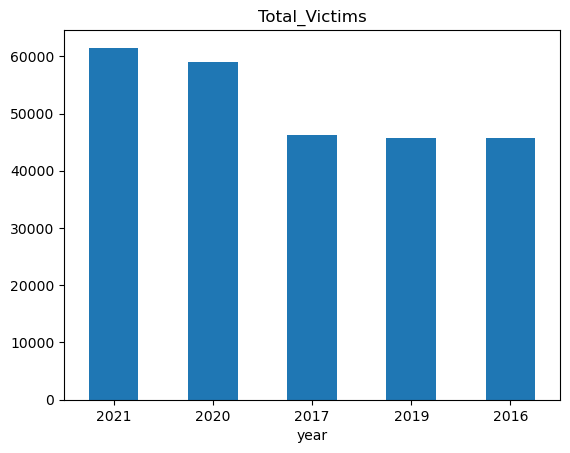

In [8]:
(df.groupby(['year'])['Total_Victims']
 .sum()
 .sort_values(ascending=False)[:5]
 .plot(kind='bar', title="Total_Victims", rot = 0)
)
plt.show()

### Top five most violent states per year

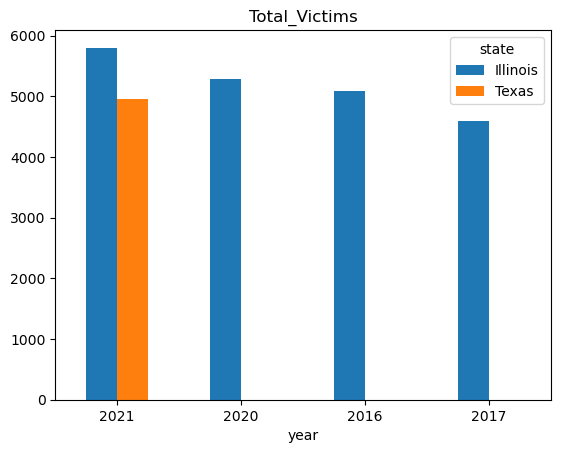

In [9]:
(df.groupby(['year','state'])['Total_Victims']
 .sum()
 .sort_values(ascending=False)[:5]
 .unstack(level=1)
 .plot(kind='bar', title="Total_Victims", rot = 0)
)
plt.show()

### Top ten most violent months per year

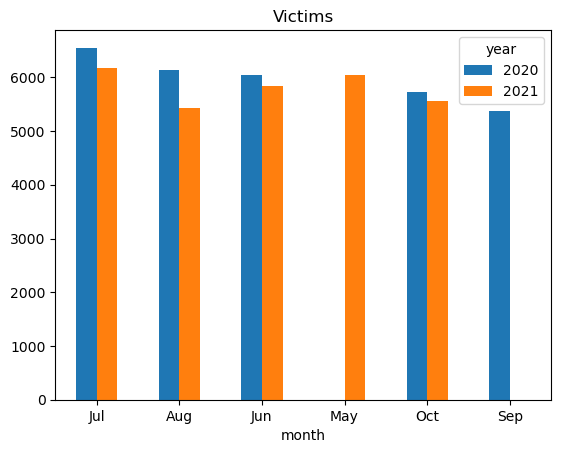

In [15]:
map_month = dict((index,month ) for index, month in enumerate(calendar.month_abbr) if month)

(df.replace({"month": map_month})
 .groupby(['year','month'])['Total_Victims']
 .sum()
 .sort_values(ascending=False)[:10]
 .unstack(level=0)
 .plot(kind='bar', title="Victims", rot = 0)
)
plt.show()

### Most violent day


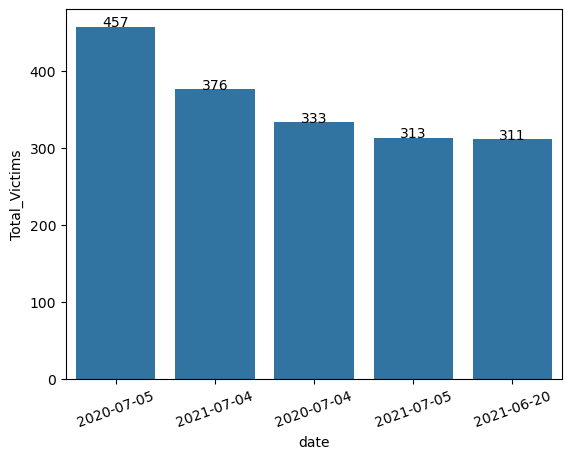

In [11]:
df_day = (df.groupby(['date'])['Total_Victims']
            .sum()
            .sort_values(ascending=False)[:5]
            .to_frame()
            .reset_index()

        )
ax = sns.barplot(data=df_day, x = 'date', y = 'Total_Victims')
ax.tick_params(axis='x', rotation=20)

for i, v in enumerate(df_day['Total_Victims']):
   ax.text(i, v + 0.2, str(v), ha='center')



From the previos Figure, we can conclude that dates related to the Independence Day present the most violent incidents

### Top five most violence city per year

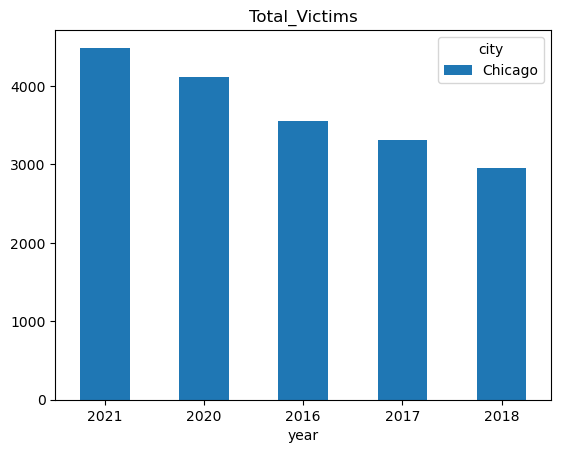

In [25]:
(df.groupby(['year','city'])['Total_Victims']
 .sum()
 .sort_values(ascending=False)[:5]
 .unstack(level=1)
 .plot(kind='bar', title="Total_Victims", rot=0)
)
plt.show()

### Top state violent incidents per year

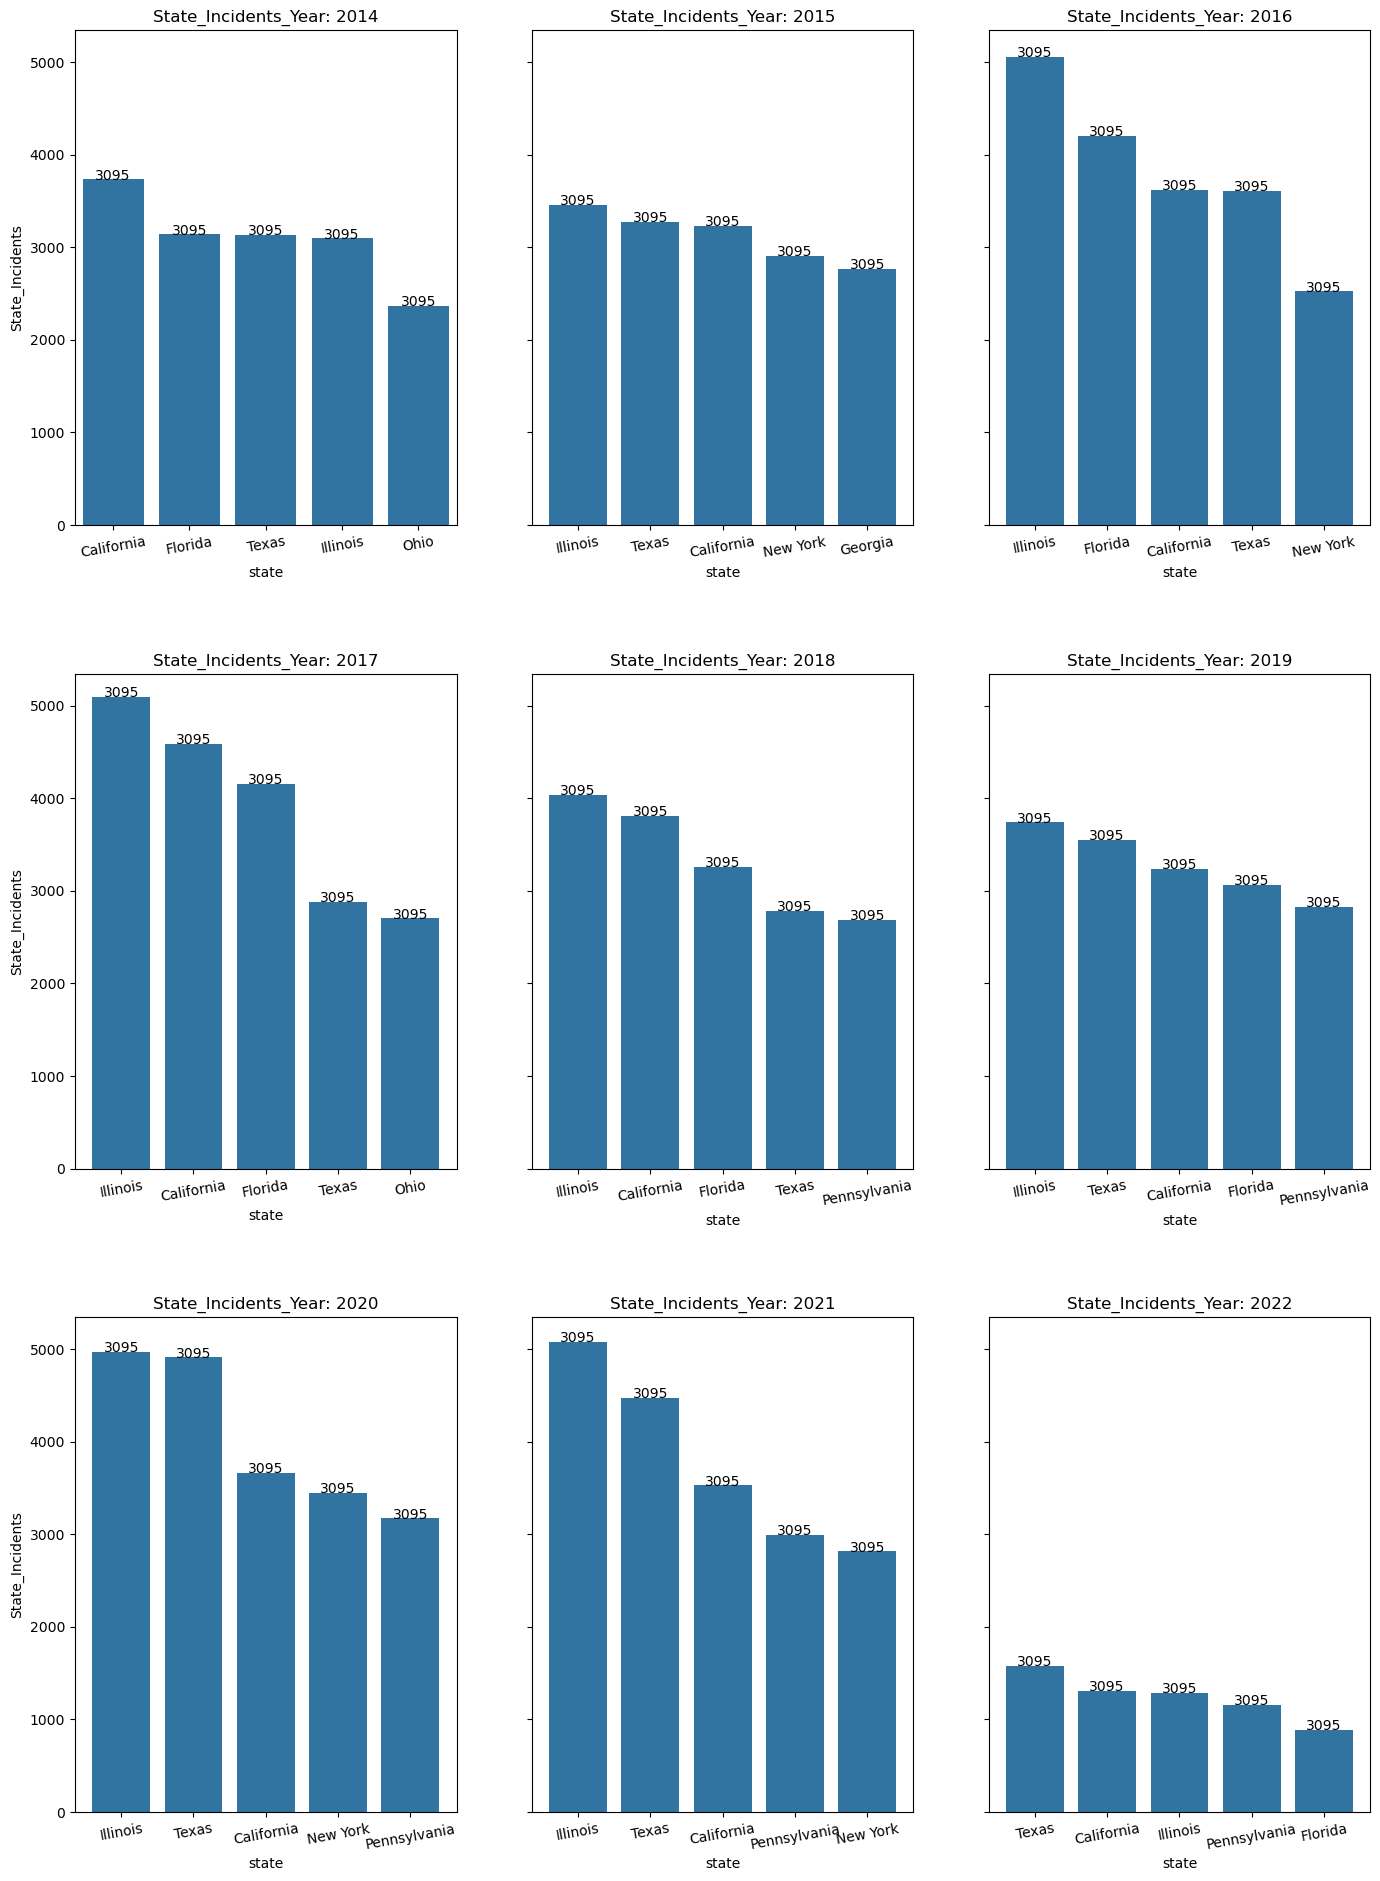

In [14]:

dates = np.array([2014, 2015,2016, 2017, 2018, 2019, 2020, 2021, 2022])
dates = dates.reshape((-1, 3))

fig, axes = plt.subplots(3, 3, figsize=(15, 20), sharey=True)

for j in range(dates.shape[0]):
    for i in range(dates.shape[1]):
        mask = df['year'] == dates[j,i]
        temp = (df[mask]
                .groupby('state')
                .agg({'state': 'count'})
                .rename(columns={'state' : 'State_Incidents'})
                .sort_values(by='State_Incidents', ascending=False)[:5]
                )
        sns.barplot(data=temp, x = temp.index, y = 'State_Incidents', ax=axes[j,i]).set(title='State_Incidents_Year: ' + str(dates[j,i]))
        axes[j,i].tick_params(axis='x', rotation=10)
        
        for index, value in enumerate(temp['State_Incidents']):
            axes[j,i].text(index, value + 0.2, str(v), ha='center')

        fig.tight_layout(pad=5.0)